# Fall Detection: Isolation Forest vs Supervised Learning
This notebook compares the performance of an unsupervised anomaly detection model (Isolation Forest) against a supervised classification model (Random Forest) using extracted features from accelerometer data.

In [157]:
import os
import pandas as pd
import zipfile

def calculate_sma(df, columns):
    return (df[columns].abs()).sum().sum() / len(df)

def extract_features_from_file(df):
    features = {}

    # Base stats for all numeric columns
    for col in df.columns:
        features[f'{col}_mean'] = df[col].mean()
        features[f'{col}_std'] = df[col].std()
        features[f'{col}_max'] = df[col].max()
        features[f'{col}_min'] = df[col].min()
        features[f'{col}_range'] = df[col].max() - df[col].min()

    # SMA for Acc and Gyro
    acc_cols = ['AccX', 'AccY', 'AccZ']
    gyro_cols = ['GyroX', 'GyroY', 'GyroZ']

    if all(col in df.columns for col in acc_cols):
        features['SMA_Acc'] = calculate_sma(df, acc_cols)
    if all(col in df.columns for col in gyro_cols):
        features['SMA_Gyro'] = calculate_sma(df, gyro_cols)

    return features

def load_dataset(root_dir):
    all_records = []

    for label in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, label)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                file_path = os.path.join(folder_path, file)

                if os.path.getsize(file_path) == 0:
                    continue

                try:
                    df = pd.read_csv(file_path)
                    if 'Unnamed: 0' in df.columns:
                        df = df.drop(columns=['Unnamed: 0'])
                    features = extract_features_from_file(df)
                    features['label'] = label
                    #features['source_file'] = file
                    all_records.append(features)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    return pd.DataFrame(all_records)

In [159]:
with zipfile.ZipFile("Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Dataset/")

In [160]:
dataset_df = load_dataset("Dataset/Dataset V4")
print(dataset_df.head())

   AccX_mean  AccX_std  AccX_max  AccX_min  AccX_range  AccY_mean  AccY_std  \
0  -0.087858  0.123203  0.287009 -0.335062    0.622070  -0.068686  0.160561   
1  -0.252270  0.095160  0.072165 -0.558694    0.630859   0.031388  0.095860   
2  -0.220107  0.046629 -0.090921 -0.354593    0.263672   0.053347  0.097314   
3  -0.130244  0.101693  0.257712 -0.378519    0.636230   0.005397  0.105654   
4  -0.204864  0.047706 -0.072366 -0.383890    0.311523   0.001256  0.100798   

   AccY_max  AccY_min  AccY_range  ...  Temperature_min  Temperature_range  \
0  0.216823 -0.525853    0.742676  ...        32.200588           1.976471   
1  0.276882 -0.324192    0.601074  ...        32.765294           1.458824   
2  0.315456 -0.245091    0.560547  ...        32.765294           1.458824   
3  0.257839 -0.365696    0.623535  ...        32.906471           1.976471   
4  0.329616 -0.335423    0.665039  ...        33.565294           1.411765   

   Altitude_mean  Altitude_std  Altitude_max  Altitude_m

In [163]:
len(dataset_df)

8922

In [165]:
dataset_df.columns

Index(['AccX_mean', 'AccX_std', 'AccX_max', 'AccX_min', 'AccX_range',
       'AccY_mean', 'AccY_std', 'AccY_max', 'AccY_min', 'AccY_range',
       'AccZ_mean', 'AccZ_std', 'AccZ_max', 'AccZ_min', 'AccZ_range',
       'Magnitude_mean', 'Magnitude_std', 'Magnitude_max', 'Magnitude_min',
       'Magnitude_range', 'GyroX_mean', 'GyroX_std', 'GyroX_max', 'GyroX_min',
       'GyroX_range', 'GyroY_mean', 'GyroY_std', 'GyroY_max', 'GyroY_min',
       'GyroY_range', 'GyroZ_mean', 'GyroZ_std', 'GyroZ_max', 'GyroZ_min',
       'GyroZ_range', 'Temperature_mean', 'Temperature_std', 'Temperature_max',
       'Temperature_min', 'Temperature_range', 'Altitude_mean', 'Altitude_std',
       'Altitude_max', 'Altitude_min', 'Altitude_range', 'SMA_Acc', 'SMA_Gyro',
       'label'],
      dtype='object')

In [167]:
dataset_df['label'] = dataset_df['label'].apply(lambda x: 1 if x.lower() == 'falls' else 0)

## Q1: Is Isolation Forest comparable to supervised models for fall detection?

### Train/test split:

split the data first, so model evaluation is based on unseen data. 
SimpleImputer only on the training data, which prevents "data leakage"

In [172]:
from sklearn.model_selection import train_test_split

X = dataset_df.drop("label", axis=1)
y = dataset_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [174]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


Synthetic Minority Oversampling Technique

It’s an oversampling technique used to balance class distribution by creating synthetic examples of the minority class (e.g., falls) instead of just duplicating existing ones.

In [177]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before resampling:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After resampling:", Counter(y_train))


Before resampling: Counter({0: 4904, 1: 2233})
After resampling: Counter({0: 4904, 1: 4904})


### Train a Random Forest (supervised):

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1213   14]
 [   8  550]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1227
           1       0.98      0.99      0.98       558

    accuracy                           0.99      1785
   macro avg       0.98      0.99      0.99      1785
weighted avg       0.99      0.99      0.99      1785



### Train a Random Forest (unsupervised):

In [182]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

iso = IsolationForest(contamination=0.25, random_state=42)
iso.fit(X_train)
y_scores = iso.decision_function(X_test)
y_iso_pred = iso.predict(X_test)
y_iso_pred = [1 if p == -1 else 0 for p in y_iso_pred]

print(confusion_matrix(y_test, y_iso_pred))
print("ROC AUC:", roc_auc_score(y_test, y_scores))


[[1003  224]
 [ 329  229]]
ROC AUC: 0.28409326591359874


## Q2: Which features are most informative?

#### After training the RandomForestClassifier, get feature importances we can discuss which features (e.g. SMA_Acc, AccX_std) matter most for fall detection

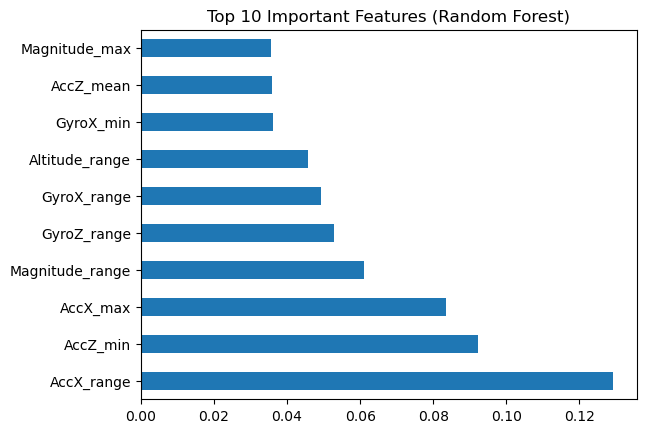

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


## Q3: How sensitive are models to imbalance or contamination?

#### Change contamination and test IsolationForest performance:

In [191]:
for rate in [0.10, 0.15, 0.25, 0.35]:
    iso = IsolationForest(contamination=rate, random_state=42)
    iso.fit(X_train)
    preds = iso.predict(X_test)
    preds = [1 if p == -1 else 0 for p in preds]
    print(f"Contamination: {rate}")
    print(confusion_matrix(y_test, preds))


Contamination: 0.1
[[1130   97]
 [ 455  103]]
Contamination: 0.15
[[1097  130]
 [ 418  140]]
Contamination: 0.25
[[1003  224]
 [ 329  229]]
Contamination: 0.35
[[891 336]
 [248 310]]


## Q4: Can PCA visually separate falls from ADLs?

What is PCA?
PCA stands for Principal Component Analysis.
It’s a technique in machine learning and statistics used mainly for:

🔹 Dimensionality Reduction — reducing the number of features in your data
🔹 Visualization — projecting complex, high-dimensional data onto 2D or 3D plots
🔹 Noise Reduction — keeping the most important patterns, discarding minor "noise"

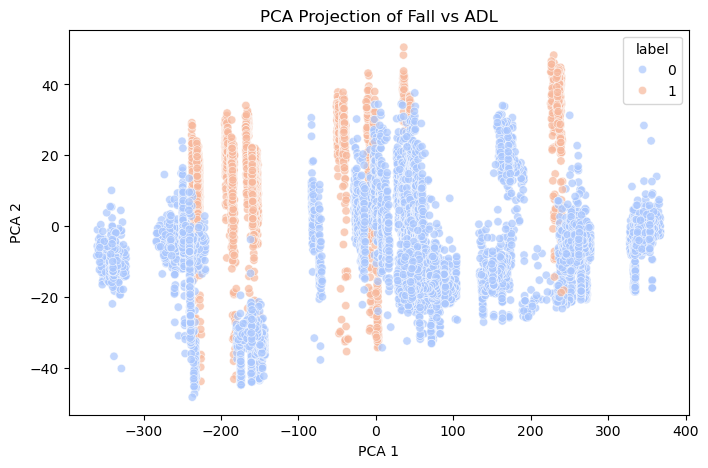

In [193]:
from sklearn.impute import SimpleImputer

# Fills NaNs with column means 
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X_reduced = PCA(n_components=2).fit_transform(X_imputed)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("PCA Projection of Fall vs ADL")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


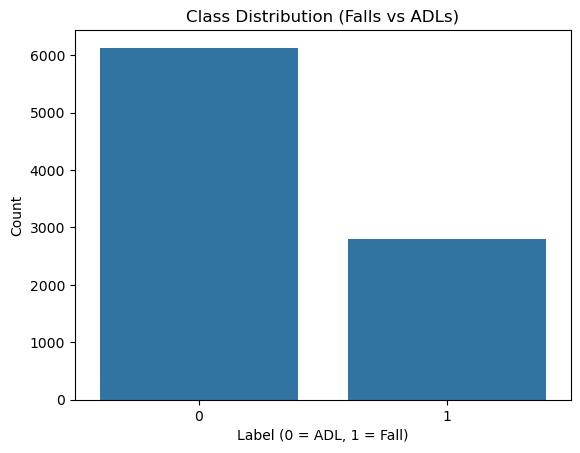

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=dataset_df['label'])
plt.title('Class Distribution (Falls vs ADLs)')
plt.xlabel('Label (0 = ADL, 1 = Fall)')
plt.ylabel('Count')
plt.show()